# Develop snow line detection method

Rainey Aberle

September 2022

### Methods tested:

1. Fill no-data pixels using the normalized histogram of snow elevations, vectorize snow-covered area, extract snowline coordinates
    
2. Solve for the optimal snow elevation percentile 
    
3. Edge detection in classified images


## Setup

In [241]:
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xarray as xr
import ee
import wxee as wx
import glob
import geopandas as gpd
import sys
from scipy import stats
import skimage.io
import skimage.feature
from skimage.measure import find_contours
from scipy.signal import medfilt
from scipy.ndimage import binary_fill_holes
from shapely.geometry import Point, LineString, shape, MultiPolygon
from shapely.ops import split

In [2]:
# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# names of study sites
site_names = ['Gulkana', 'SCascade', 'Sperry', 'Wolverine']
# path for output figures
figures_out_path = base_path+'figures/'

# add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

In [3]:
# Authenticate Google Earth Engine (GEE)
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## 1. Fill no-data pixels using the normalized histogram of snow elevations, identify contours in binary snow image, filter contours

Downloading:   0%|          | 0.00/31.4k [00:00<?, ?iB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


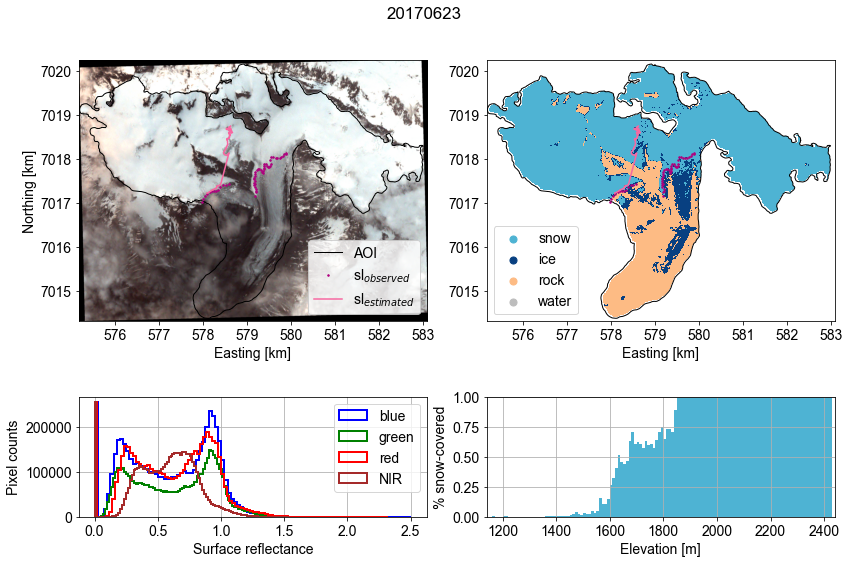

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


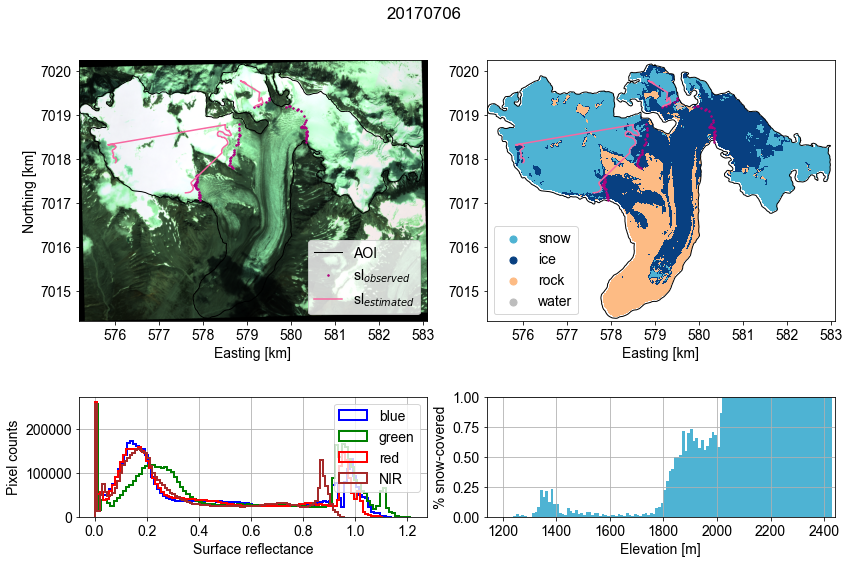

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


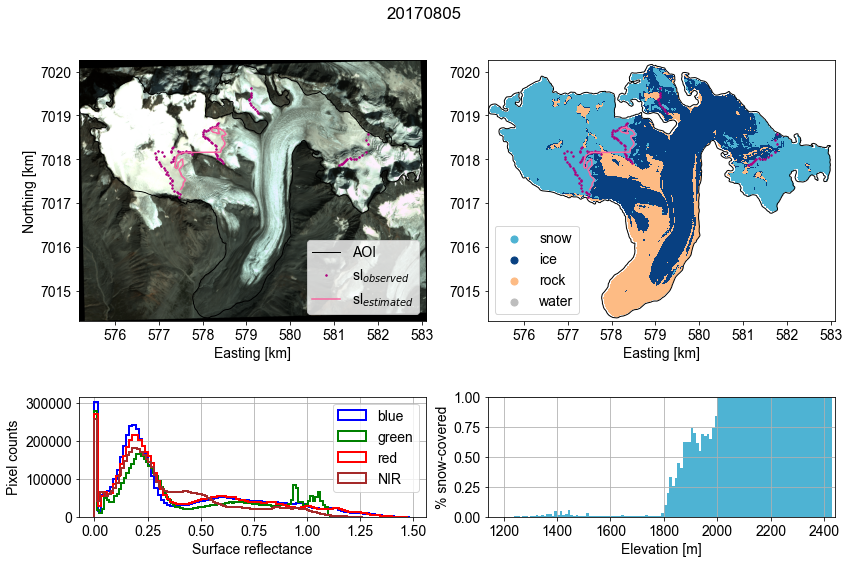

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


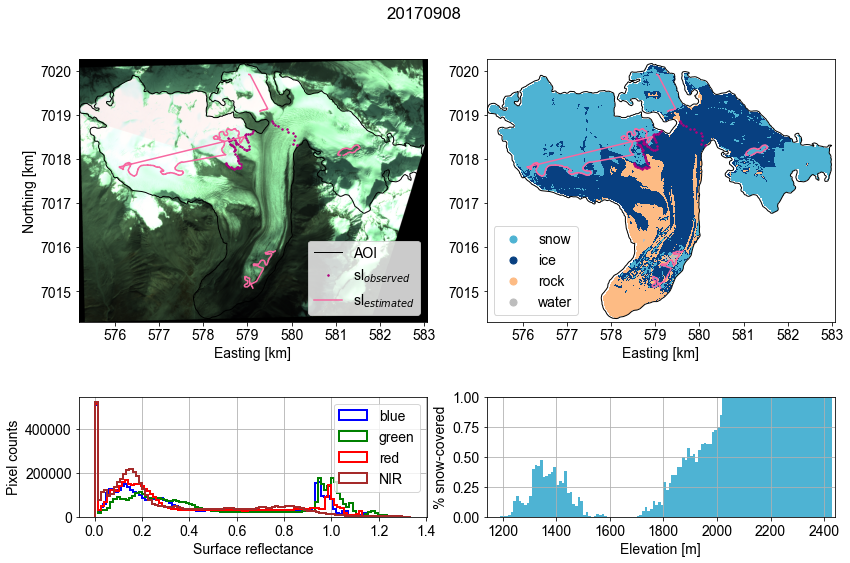

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


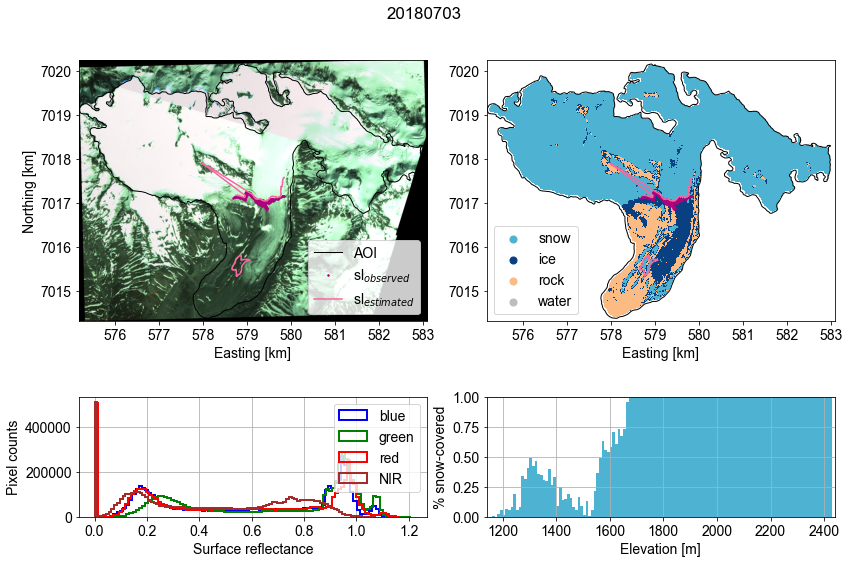

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


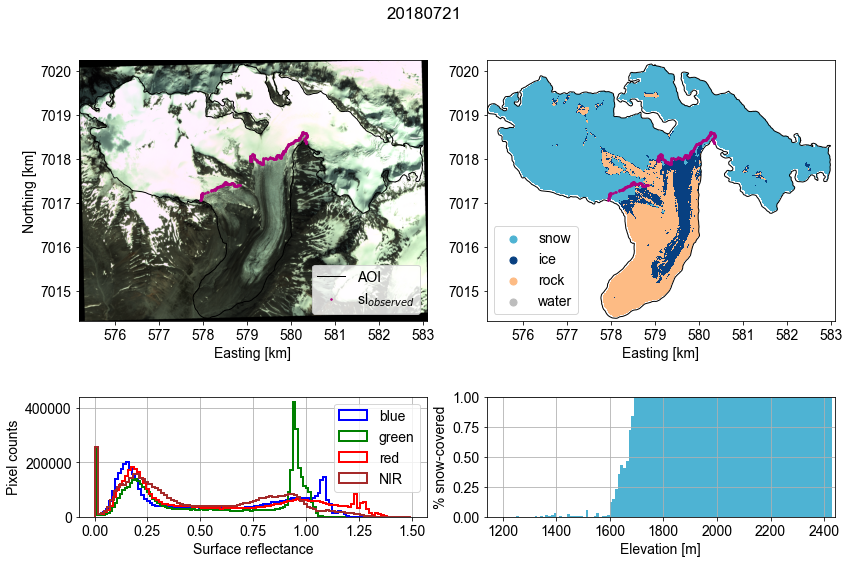

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


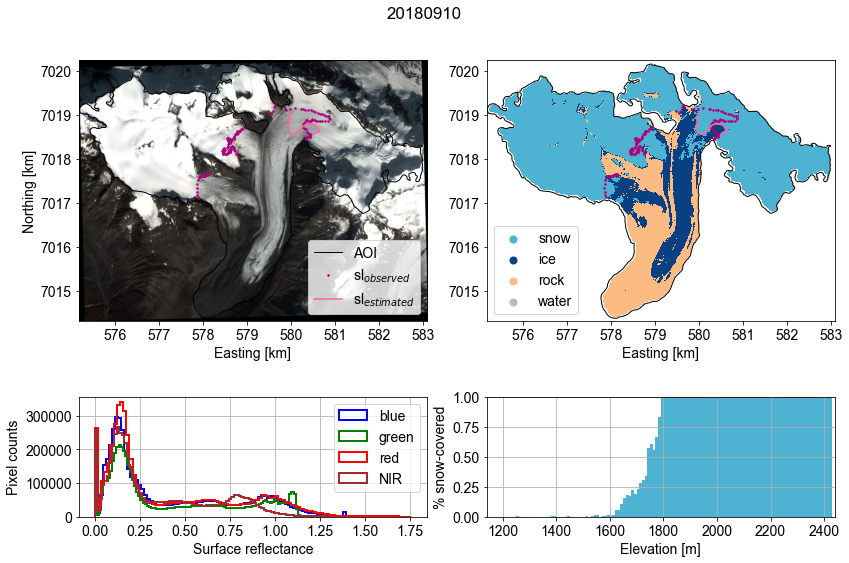

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


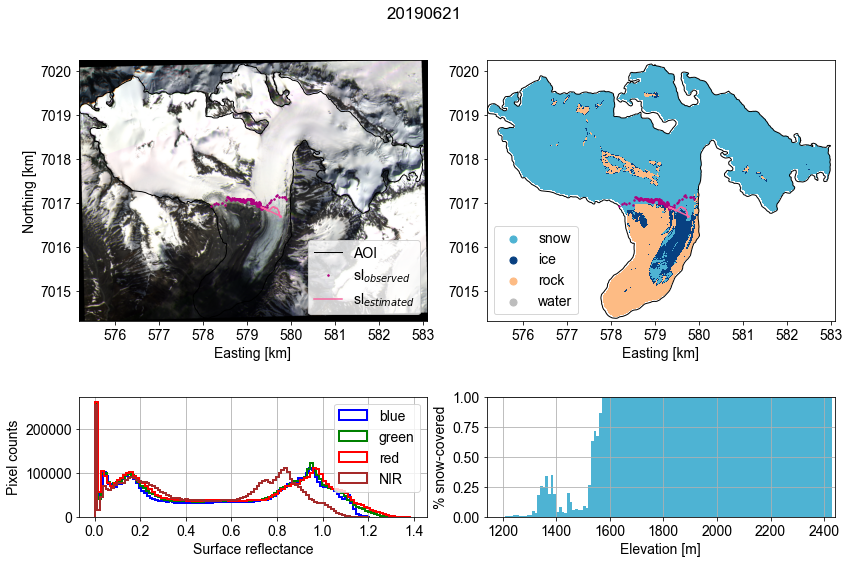

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


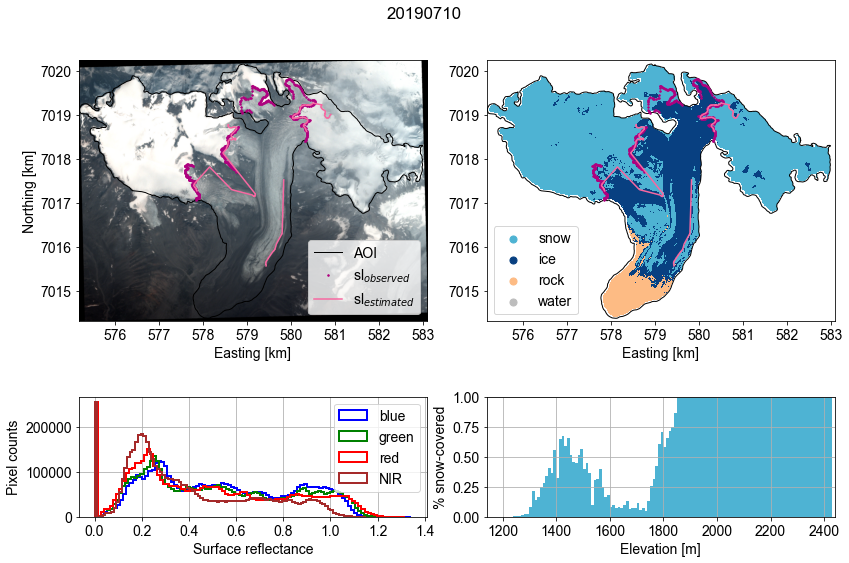

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


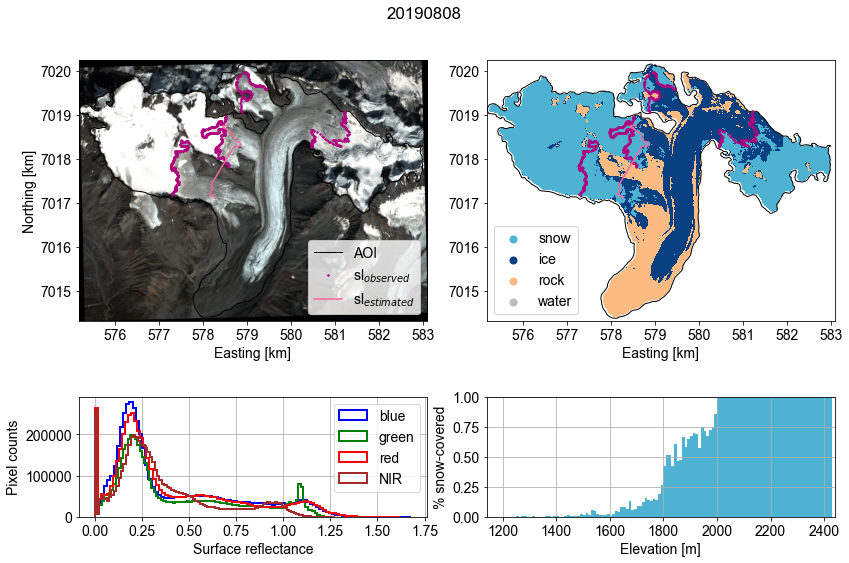

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


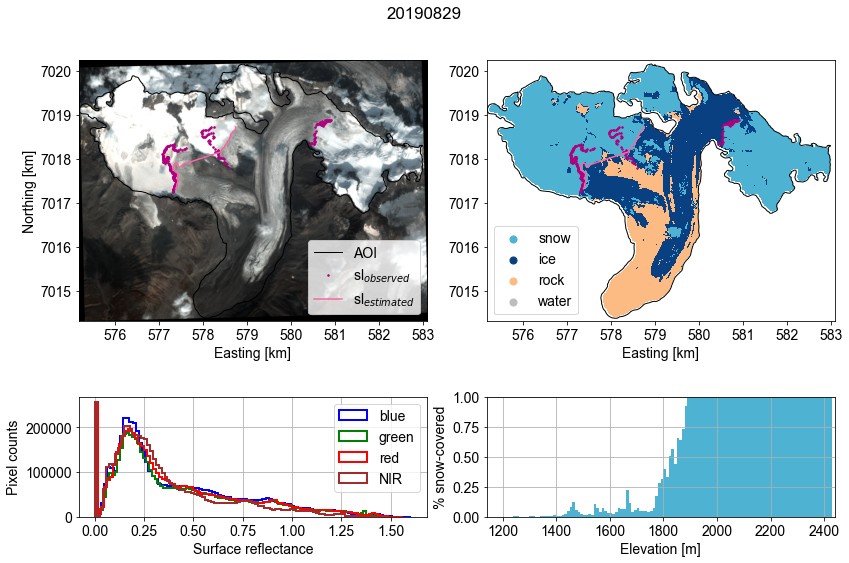

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


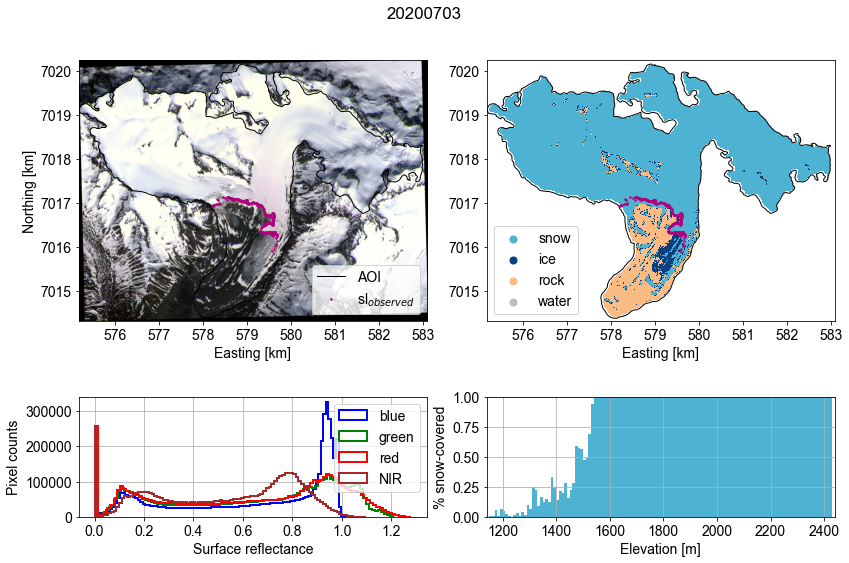

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


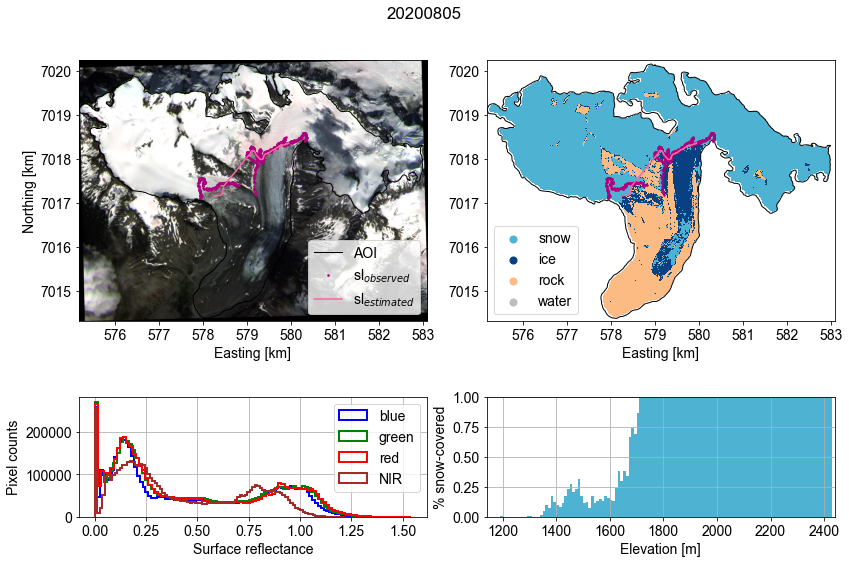

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


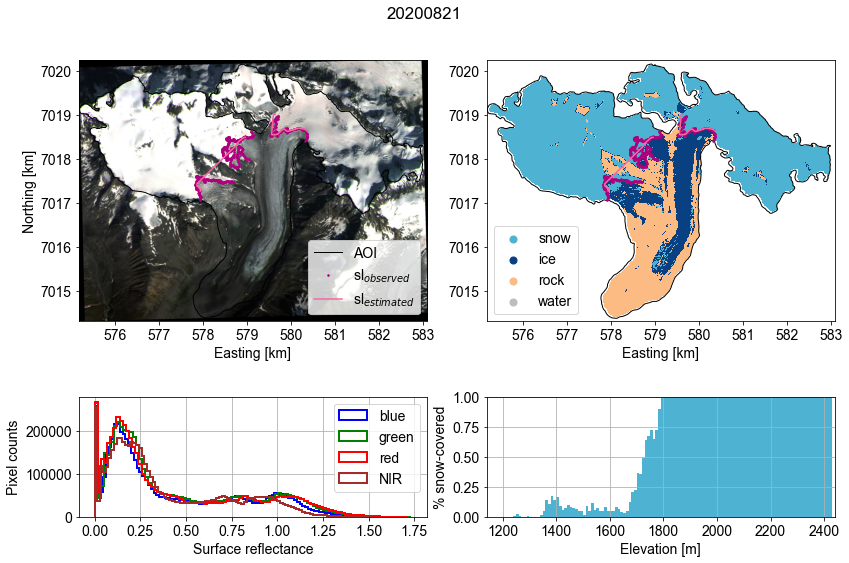

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


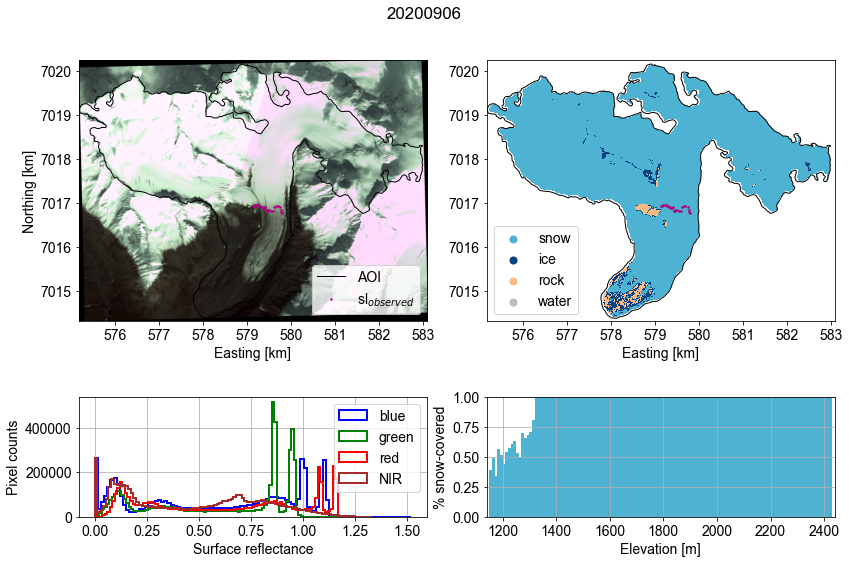

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


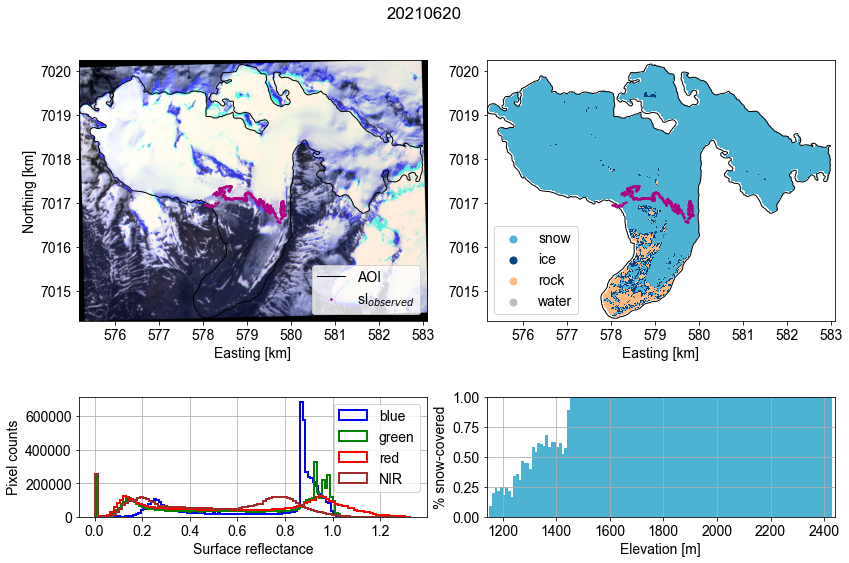

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


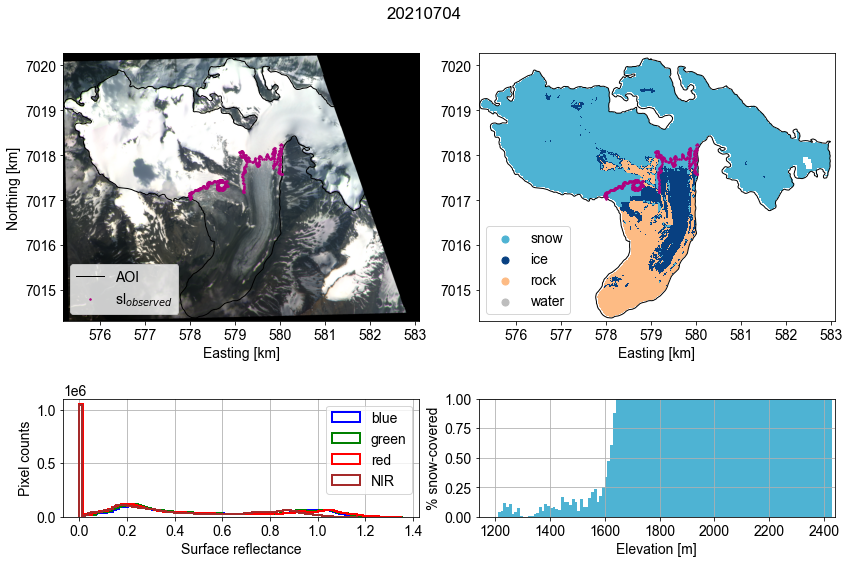

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


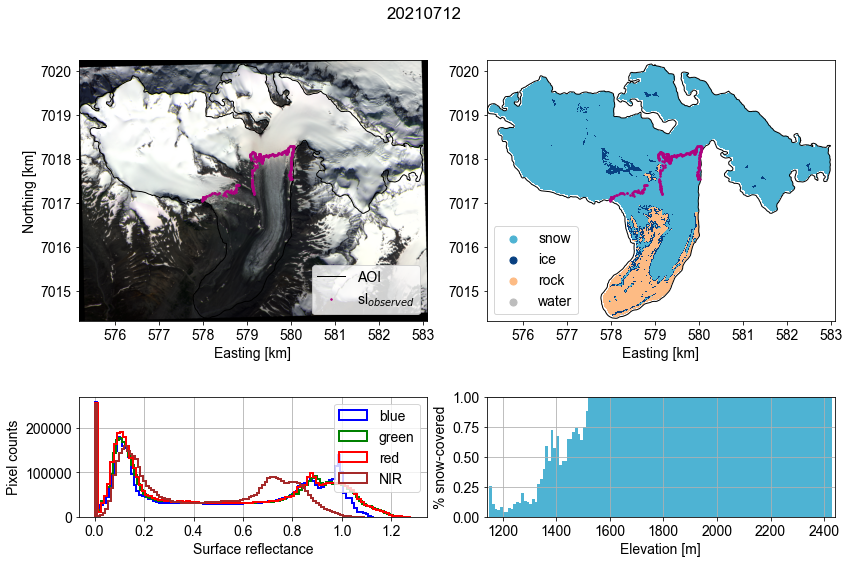

Downloading:   0%|          | 0.00/8.06k [00:00<?, ?iB/s]

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1264/3382423095.py:95: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


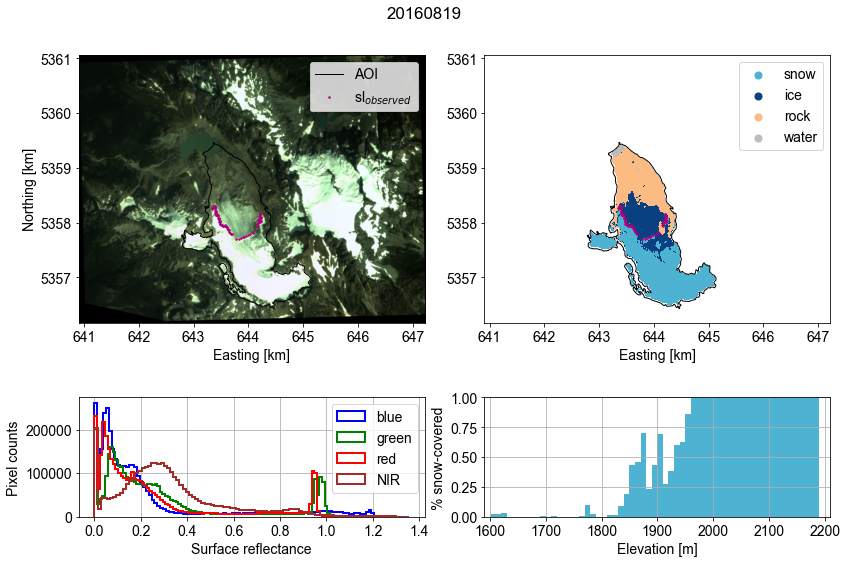

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1264/3382423095.py:95: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


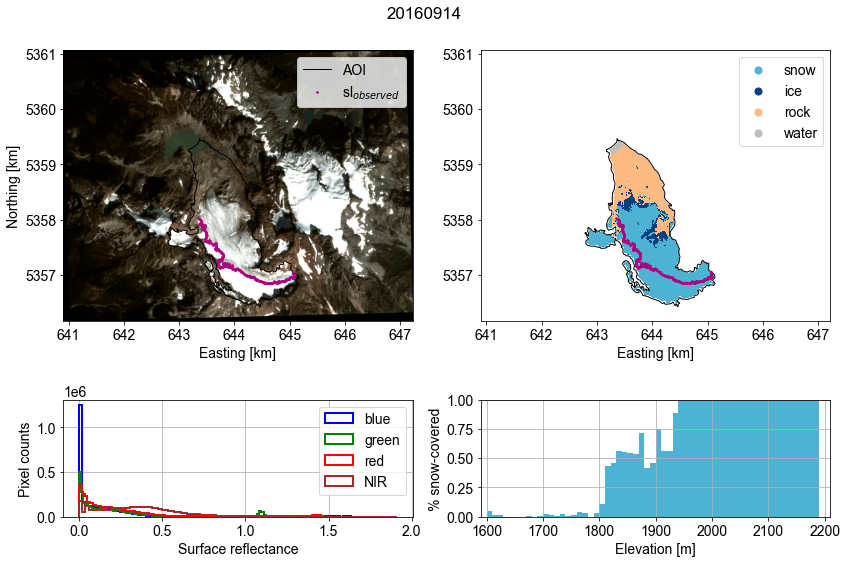

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1264/3382423095.py:95: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


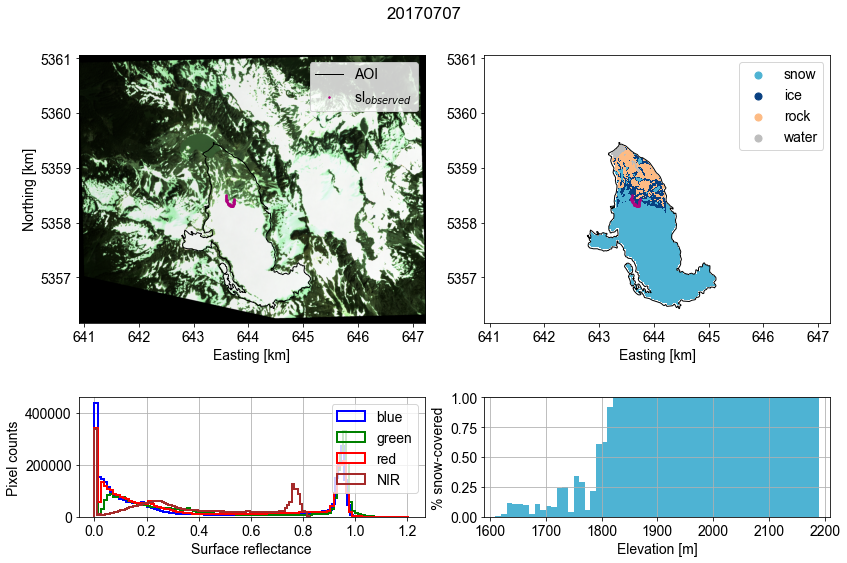

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1264/3382423095.py:95: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM


KeyboardInterrupt: 

In [268]:
# ----Iniitalize observed and estimated snow line median elevation
sl_obs_elev_medians = []
sl_est_elev_medians = []

# -----Loop through sites
for site_name in site_names:    
    
    # define path to classified snow images
    im_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/'

    # define path to digitized snow lines
    sl_obs_path = base_path + '../snowline-package/' + site_name + '/snowlines/'

    # load AOI as gpd.GeoDataFrame
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)

    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)

    # load snow line shapefile names
    sl_obs_fns = glob.glob(sl_obs_path + '*.shp')
    sl_obs_fns.sort() # sort chronologically

    # initialize variables
    sl_obs_elevs = [None]*len(sl_obs_fns) # observed snow elevations
    datetimes = [None]*len(sl_obs_fns) # image datetimes

    # loop through observed snow lines
    for sl_obs_fn in sl_obs_fns:

        # -----Load datasets
        # load snow line
        sl_obs = gpd.read_file(sl_obs_fn)
        # extract date from filename
        date = sl_obs_fn.split('/'+site_name+'_')[1][0:8]
        # reproject snow line to UTM
        sl_obs_UTM = sl_obs.to_crs(str(AOI_UTM.crs.to_epsg()))
        # open adjusted image of the same date
        im_adj_fn = glob.glob(im_path + 'adjusted-filtered/*' + date + '*.tif')[0] # define file name
        im_adj = rxr.open_rasterio(im_adj_fn) # open image as xarray.DataArray
        im_adj = im_adj / 1e4
         # open classified image from the same date
        im_classified_fn = glob.glob(im_path + 'classified/*' + date + '*.tif')[0] # define file name
        im_classified = rxr.open_rasterio(im_classified_fn) # open image as xarray.DataArray
        # create no data mask
        no_data_mask = xr.where(im_classified==-9999, 1, 0).data[0]
        # convert to polygons
        no_data_polygons = []
        for s, value in rio.features.shapes(no_data_mask.astype(np.int16), 
                                            mask=(no_data_mask >0), transform=rio.open(im_adj_fn).transform):
            no_data_polygons.append(shape(s))
        no_data_polygons = MultiPolygon(no_data_polygons)
        # mask no data points in classified image
        im_classified = im_classified.where(im_classified!=-9999) # now, remove no data values
        
        # -----Interpolate elevations at observed snow line
        sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[0].xy[0], 
                                                     sl_obs_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_obs_elev_median = np.nanmedian(sl_obs_elev)
        sl_obs_elev_medians = sl_obs_elev_medians + [sl_obs_elev_median] # add to list
       
        # -----Mask the DEM using the AOI
        # create AOI mask with DEM cordinates
        mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                          out_shape=(len(DEM.y), len(DEM.x)),
                                          transform=DEM.transform,
                                          invert=True)
        # convert mask to xarray DataArray
        mask = xr.DataArray(mask , dims=("y", "x"))
        # mask DEM values outside the AOI
        DEM_AOI = DEM.where(mask == True)

        # -----Interpolate DEM at the image coordinates
        # grab image indices
        band, x, y = im_classified.indexes.values() 
        # interpolate DEM at image coordinates
        DEM_AOI_interp = DEM_AOI.interp(x=x, y=y, method="nearest") 

        # -----Determine snow covered elevations
        DEM_AOI_interp_snow = DEM_AOI_interp.where(im_classified<=2) # mask pixels not classified as snow
        snow_est_elev = DEM_AOI_interp_snow.elevation.data.flatten() # create array of snow-covered pixel elevations

        # -----Calculate elevation histograms
        # determine histogram bins using DEM elevation range
        elev_min = np.fix(np.nanmin(DEM_AOI_interp.elevation.data.flatten())/10)*10
        elev_max = np.round(np.nanmax(DEM_AOI_interp.elevation.data.flatten())/10)*10
        bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
        bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2
        # calculate elevation histograms
        H_DEM = np.histogram(DEM_AOI_interp.elevation.data.flatten(), bins=bin_edges)[0]
        H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
        H_snow_est_elev_norm = H_snow_est_elev / H_DEM

        # -----All pixels above the first elevation band with > 75% snow-coverage = snow
        # determine elevation with > 75% snow coverage
        elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]
        # set all pixels above the elev_75_snow to snow (1)
        im_classified_adj = xr.where(DEM_AOI_interp.elevation > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
        im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
        
        # -----Generate and filter binary snow matrix
        # create binary snow matrix
        im_binary = xr.where(im_classified_adj <=2, 1, 0).data
        # apply median filter to binary image with kernel_size of 33 pixels (~99 m)
        im_binary_filt = medfilt(im_binary, kernel_size=33)
        # fill holes in binary image (0s within 1s = 1)
        im_binary_filt_no_holes = binary_fill_holes(im_binary_filt)

        # -----Find contours between 0 and 1 in binary image
        # Find contours at a constant value of 0.5 (between 0 and 1)
        contours = find_contours(im_binary_filt_no_holes, 0.5)
        # convert contour points to image coordinates
        contours_coords = []
        for contour in contours: 
            ix = np.round(contour[:,1]).astype(int)
            iy = np.round(contour[:,0]).astype(int)
            coords = (im_adj.isel(x=ix, y=iy).x.data, # image x coordinates
                      im_adj.isel(x=ix, y=iy).y.data) # image y coordinates
            # zip points together
            xy = list(zip([x for x in coords[0]], 
                          [y for y in coords[1]]))
            contours_coords = contours_coords + [xy]

        # -----Extract snow lines (sl) from contours
        # filter contours along no data mask (i.e., along glacier outline or data gaps)
        sl_est = [] # initialize list of snow lines
        min_sl_length = 1000 # minimum snow line length
        for c in contours_coords:
            # create array of points
            c_points =  [Point(x,y) for x,y in c]
            # loop through points 
            line_points = [] # initialize list of points to use in snow line
            for point in c_points:
                # calculate distance from the point to the no data polygons and the AOI boundary
                distance_no_data = no_data_polygons.distance(point)
                distance_AOI = AOI_UTM.boundary[0].distance(point)
                # only include points 200 m from both
                if (distance_no_data >= 200) and (distance_AOI >=200):
                    line_points = line_points + [point]
            if line_points: # if list of line points is not empty
                if len(line_points) > 1: # must have at least two points to create a LineString
                    line = LineString([(p.xy[0][0], p.xy[1][0]) for p in line_points])
                    if line.length > min_sl_length:
                        sl_est = sl_est + [line]
                        
        # NOT WORKING PROPERLY (missing some lines): split lines with points more than 1 km apart and filter by length
        # sl_est_filt = [] # initialize list of filtered snow lines
        # min_sl_length = 500
        # for line in sl_est:
        #     # extract line x and y coordinates
        #     coords = list(line.coords)
        #     # initialize binary array of where to split
        #     split_list = np.zeros(len(line.coords)) 
        #     # loop through points
        #     for i in np.arange(0,len(coords)):
        #         point = Point(coords[i])
        #         if i!=0:
        #             # calculate distance between point and previous point
        #             distance = point.distance(Point(coords[i-1]))
        #             # set split to 1 if distance is greater than 200 m
        #             if distance > 200:
        #                 split_list[i] = 1
        #     if np.any(split_list==1):
        #         # initialize binary list of where to split the line
        #         isplit = np.ravel(np.where(split_list==1))
        #         for i in np.arange(0,len(isplit)):
        #             if i==0:
        #                 line_split = LineString(coords[0:isplit[i]])
        #             else:
        #                 line_split = LineString(coords[isplit[i-1]:isplit[i]])
        #             # concatenate split line to sl_est_filt if greater than min_sl_length
        #             if line_split.length > min_sl_length:
        #                 sl_est_filt = sl_est_filt + [line_split] 
        #     else:
        #         # concatenate line to sl_est_filt if greater than min_sl_length
        #         if line.length > min_sl_length:
        #             sl_est_filt = sl_est_filt + [line]   
        
        # -----Interpolate elevation at snow line points
        # compile all line coordinates into arrays of x- and y-coordinates 
        xpts, ypts = [], []
        for line in sl_est:
            xpts = xpts + [x for x in line.coords.xy[0]]
            ypts = ypts + [y for y in line.coords.xy[1]]  
        xpts, ypts = np.array(xpts).flatten(), np.array(ypts).flatten()
        # interpolate elevation at snow line points
        sl_est_elev = [DEM.sel(x=x, y=y, method='nearest').elevation.data[0] 
                       for x, y in list(zip(xpts, ypts))]
        # calculate median snow line elevation
        sl_est_elev_median = np.nanmedian(sl_est_elev)
        sl_est_elev_medians = sl_est_elev_medians + [sl_est_elev_median] # add to list
        
        # -----Plot results
        contour = None
        fig, ax, sl_points_AOI = f.plot_im_classified_histogram_contour(im_adj, im_classified_adj, DEM, AOI_UTM, contour)
        # plot observed snow line elevation
        ax[0].plot([x/1e3 for x in sl_obs_UTM.geometry[0].xy[0]], 
                   [y/1e3 for y in sl_obs_UTM.geometry[0].xy[1]], 
                   '.', color='#ae017e', label='sl$_{observed}$', markersize=3) 
        ax[1].plot([x/1e3 for x in sl_obs_UTM.geometry[0].xy[0]], 
                   [y/1e3 for y in sl_obs_UTM.geometry[0].xy[1]], 
                   '.', color='#ae017e', label='_nolegend_', markersize=3) 
        # plot estimated snow line elevation
        # ax[0].plot([x/1e3 for x in xpts], [y/1e3 for y in ypts], '.', 
        #            color='#f768a1', markersize=1, label='sl$_{estimated}$')
        # ax[1].plot([x/1e3 for x in xpts], [y/1e3 for y in ypts], '.', 
        #            color='#f768a1', markersize=1, label='_nolegend_')
        for line, i  in list(zip( sl_est, np.arange(0,len(sl_est)-1) )):
            if i==0:
                ax[0].plot([x/1e3 for x in line.coords.xy[0]], 
                           [y/1e3 for y in line.coords.xy[1]],
                           '-', color='#f768a1', label='sl$_{estimated}$') 
            else: 
                ax[0].plot([x/1e3 for x in line.coords.xy[0]], 
                           [y/1e3 for y in line.coords.xy[1]],
                           '-', color='#f768a1', label='_nolegend_')                 
            ax[1].plot([x/1e3 for x in line.coords.xy[0]], 
                       [y/1e3 for y in line.coords.xy[1]],
                       '-', color='#f768a1', label='_nolegend_') 
        # add legends
        ax[0].legend(loc='best')
        ax[1].legend(loc='best')
        if contour is not None:
            ax[3].set_title('Contour = ' + str(np.round(contour,1)) + ' m')
        fig.suptitle(date)
        plt.show()

# -----Plot median snow line elevation
fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.plot(np.arange(0, len(sl_obs_elev_medians)), 
         [x-y for x, y in list(zip(sl_est_elev_medians, sl_obs_elev_medians))], 
         '.b', label='observed')
ax2.set_xlabel('observation #')
ax2.set_ylabel('Misfit [m]')
ax2.set_title('Median snow line elevation misfit (est. - obs.)')
ax2.grid()
plt.show()

## 2. Solve for the optimal snow elevation percentile 

In [ ]:
# -----Loop through sites
percentiles = [] # initialize optimal percentiles for estimating snow line elevation
misfits = [] # initialize misfits between estimated and observed snow line elevation
for site_name in site_names:
    
    # define path to classified snow images
    im_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/'
    
    # define path to digitized snow lines
    sl_path = base_path + '../snowline-package/' + site_name + '/snowlines/'
    
    # load AOI as geopandas DataFrame
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
    # create a mask using the AOI
    mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                      out_shape=(len(DEM.y), len(DEM.x)),
                                      transform=DEM.transform,
                                      invert=True)
    # convert to xarray DataArray
    mask = xr.DataArray(mask , dims=("y", "x"))
    # mask the DEM outside the AOI
    DEM_AOI = DEM.where(mask == True)

    # load snow line file names
    sl_obs_fns = glob.glob(sl_path+'*.shp')
    sl_obs_fns.sort() # sort chronologically
    
    # initialize variables
    sl_obs_elev_medians = [None]*len(sl_obs_fns) # median observed snow line elevations
    sl_est_elevs = [None]*len(sl_obs_fns) # median estimated snow line elevations
    # loop through observed snow lines
    for sl_obs_fn in sl_obs_fns:
        
        # load snow line
        sl_obs = gpd.read_file(sl_obs_fn)
        # extract date from filename
        date = sl_obs_fn.split('/'+site_name+'_')[1][0:8]
        # reproject snow line to UTM
        sl_obs_UTM = sl_obs.to_crs(str(AOI_UTM.crs.to_epsg()))
        # interpolate elevations at snow line
        sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[0].xy[0], 
                                                     sl_obs_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_obs_elev_median = np.nanmedian(sl_obs_elev)
        sl_obs_elev_medians = sl_obs_elev_medians + [sl_obs_elev_median] # add to list

        # open adjusted image of the same date
        im_adj_fn = glob.glob(im_path + 'adjusted-filtered/*' + date + '*.tif')[0] # define file name
        im_adj = rxr.open_rasterio(im_adj_fn) # open image as xarray.DataArray
        im_adj = im_adj.where(im_adj!=-9999) # remove no data values
        im_adj = im_adj / 10000 # account for surface reflectance scalar multiplier

        # open classified image from the same date
        im_classified_fn = glob.glob(im_path + 'classified/*' + date + '*.tif')[0] # define file name
        im_classified = rxr.open_rasterio(im_classified_fn) # open image as xarray.DataArray
        im_classified = im_classified.where(im_classified!=-9999) # remove no data values

        # mask the DEM using the AOI
        mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                          out_shape=(len(DEM.y), len(DEM.x)),
                                          transform=DEM.transform,
                                          invert=True)
        # convert mask to xarray DataArray
        mask = xr.DataArray(mask , dims=("y", "x"))
        # mask DEM values outside the AOI
        DEM_AOI = DEM.where(mask == True)
        
        # interpolate DEM to the image coordinates
        band, x, y = im_classified.indexes.values() # grab indices of image
        DEM_AOI_interp = DEM_AOI.interp(x=x, y=y, method="nearest") # interpolate DEM to image coordinates

        # determine snow covered elevations
        DEM_AOI_interp_snow = DEM_AOI_interp.where(im_classified<=2) # mask pixels not classified as snow
        snow_est_elev = DEM_AOI_interp_snow.elevation.data.flatten() # create array of snow-covered pixel elevations

        # determine bins to use in histograms
        elev_min = np.fix(np.nanmin(DEM_AOI_interp.elevation.data.flatten())/10)*10
        elev_max = np.round(np.nanmax(DEM_AOI_interp.elevation.data.flatten())/10)*10
        bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
        bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2

        # calculate elevation histograms
        H_DEM = np.histogram(DEM_AOI_interp.elevation.data.flatten(), bins=bin_edges)[0]
        H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
        H_snow_est_elev_norm = H_snow_est_elev / H_DEM

        # determine elevation with > 75% snow coverage
        elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]

        # set all pixels above the elev_75_snow to snow (1)
        im_classified_adj = xr.where(DEM_AOI_interp.elevation > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
        im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
        
        # re-determine snow-covered elevations using adjusted image
        DEM_AOI_interp_snow_adj = DEM_AOI_interp.where(im_classified_adj<=2) # mask pixels not classified as snow
        snow_est_elev_adj = DEM_AOI_interp_snow_adj.elevation.data.flatten() # create array of snow-covered pixel elevations
        snow_est_elev_adj = snow_est_elev_adj[~np.isnan(snow_est_elev_adj)] # remove NaN values
        
        # determine the optimal percentile for estimating snow line elevation in classified image
        # using the median observed snow line elevation
        percentile = stats.percentileofscore(snow_est_elev_adj, sl_obs_elev_median, kind='rank')
        percentiles = percentiles + [percentile] # concatenate to list
        
        # extract snow line elevation in the classified image using the optimal percentile
        sl_est_elev = np.nanpercentile(snow_est_elev_adj, percentile)
        sl_est_elevs = sl_est_elevs + [sl_est_elev]
        
        # plot results
        fig, ax, sl_points_AOI = f.plot_im_classified_histogram_contour(im_adj, im_classified_adj, DEM, AOI_UTM, sl_est_elev)
        # plot snow observed snow line elevation
        ax[0].plot([x/1e3 for x in sl_obs_UTM.geometry[0].xy[0]], 
                   [y/1e3 for y in sl_obs_UTM.geometry[0].xy[1]], 
                   '.', color='#ae017e', label='sl$_{observed}$', markersize=3) 
        ax[1].plot([x/1e3 for x in sl_obs_UTM.geometry[0].xy[0]], 
                   [y/1e3 for y in sl_obs_UTM.geometry[0].xy[1]], 
                   '.', color='#ae017e', label='_nolegend_', markersize=3)  
        # add legends
        ax[0].legend(loc='best')
        ax[1].legend(loc='best')
        ax[3].set_title('Contour = P'+str(np.round(percentile,2)))
        fig.suptitle(date)
        plt.show()

# Display boxplot of percentiles
plt.boxplot(percentiles)
plt.title('Percentiles distribution')
plt.show()

# Determine median optimal snow elevation percentile
percentiles_median = np.median(percentiles)
print('Median optimal snow elevation percentile = ', np.round(percentiles_median,2))

#### Plot classified images with optimal snow elevation percentile and observed snow line

In [ ]:
# -----Loop through sites
misfits = []    # initialize list of misfits between 
                # observed and estimated snow line elevation
for site_name in site_names:
    
    # define path to classified snow images
    im_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/'
    
    # define path to digitized snow lines
    sl_path = base_path + '../snowline-package/' + site_name + '/snowlines/'
    
    # load AOI as gpd.GeoDataFrame
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)

    # load snow line shapefile names
    sl_obs_fns = glob.glob(sl_path+'*.shp')
    sl_obs_fns.sort() # sort chronologically
    
    # initialize variables
    sl_obs_elev_medians = [None]*len(sl_obs_fns) # median observed snow line elevations
    sl_est_elevs = [None]*len(sl_obs_fns) # estimated snow line elevation (i.e., optimal percentile of snow elevations)
    # loop through observed snow lines
    for sl_obs_fn in sl_obs_fns:
        
        # load snow line
        sl_obs = gpd.read_file(sl_obs_fn)
        # extract date from filename
        date = sl_obs_fn.split('/'+site_name+'_')[1][0:8]
        # reproject snow line to UTM
        sl_obs_UTM = sl_obs.to_crs(str(AOI_UTM.crs.to_epsg()))
        # interpolate elevations at snow line
        sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[0].xy[0], 
                                                     sl_obs_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_obs_elev_median = np.nanmedian(sl_obs_elev)
        sl_obs_elev_medians = sl_obs_elev_medians + [sl_obs_elev_median] # add to list

        # open adjusted image of the same date
        im_adj_fn = glob.glob(im_path + 'adjusted-filtered/*' + date + '*.tif')[0] # define file name
        im_adj = rxr.open_rasterio(im_adj_fn) # open image as xarray.DataArray
        im_adj = im_adj.where(im_adj!=-9999) # remove no data values
        im_adj = im_adj / 10000 # account for surface reflectance scalar multiplier

        # open classified image from the same date
        im_classified_fn = glob.glob(im_path + 'classified/*' + date + '*.tif')[0] # define file name
        im_classified = rxr.open_rasterio(im_classified_fn) # open image as xarray.DataArray
        im_classified = im_classified.where(im_classified!=-9999) # remove no data values

        # mask the DEM using the AOI
        mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                          out_shape=(len(DEM.y), len(DEM.x)),
                                          transform=DEM.transform,
                                          invert=True)
        # convert mask to xarray DataArray
        mask = xr.DataArray(mask , dims=("y", "x"))
        # mask DEM values outside the AOI
        DEM_AOI = DEM.where(mask == True)
        
        # interpolate DEM to the image coordinates
        band, x, y = im_classified.indexes.values() # grab indices of image
        DEM_AOI_interp = DEM_AOI.interp(x=x, y=y, method="nearest") # interpolate DEM to image coordinates

        # determine snow covered elevations
        DEM_AOI_interp_snow = DEM_AOI_interp.where(im_classified<=2) # mask pixels not classified as snow
        snow_est_elev = DEM_AOI_interp_snow.elevation.data.flatten() # create array of snow-covered pixel elevations

        # determine bins to use in histograms
        elev_min = np.fix(np.nanmin(DEM_AOI_interp.elevation.data.flatten())/10)*10
        elev_max = np.round(np.nanmax(DEM_AOI_interp.elevation.data.flatten())/10)*10
        bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
        bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2

        # calculate elevation histograms
        H_DEM = np.histogram(DEM_AOI_interp.elevation.data.flatten(), bins=bin_edges)[0]
        H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
        H_snow_est_elev_norm = H_snow_est_elev / H_DEM

        # determine elevation with > 75% snow coverage
        elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]

        # set all pixels above the elev_75_snow to snow (1)
        im_classified_adj = xr.where(DEM_AOI_interp.elevation > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
        im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
        
        # re-determine snow-covered elevations using adjusted image
        DEM_AOI_interp_snow_adj = DEM_AOI_interp.where(im_classified_adj<=2) # mask pixels not classified as snow
        snow_est_elev_adj = DEM_AOI_interp_snow_adj.elevation.data.flatten() # create array of snow-covered pixel elevations
        snow_est_elev_adj = snow_est_elev_adj[~np.isnan(snow_est_elev_adj)] # remove NaN values
        
        # extract snow line elevation in the classified image using the optimal percentile
        sl_est_elev = np.nanpercentile(snow_est_elev_adj, percentiles_median)
        sl_est_elevs = sl_est_elevs + [sl_est_elev]
        print('Observed snow line elevation: ', sl_obs_elev_median, ' m')
        print('Estimated snow line elevation: ', sl_est_elev, ' m')
        
        # estimate misfit between observed and estimated snow line elevation
        # misfit = estimated - observed
        misfit =  sl_est_elev - sl_obs_elev_median
        print('Misfit: ' + str(misfit) + ' m')
        misfits = misfits + [misfit]
        
        # plot results
        fig, ax, sl_points_AOI = f.plot_im_classified_histogram_contour(im_adj, im_classified_adj, DEM, AOI_UTM, sl_est_elev)
        # plot snow observed snow line elevation
        ax[0].plot([x/1e3 for x in sl_obs_UTM.geometry[0].xy[0]], 
                   [y/1e3 for y in sl_obs_UTM.geometry[0].xy[1]], 
                   '.', color='#ae017e', label='sl$_{observed}$', markersize=3) 
        ax[1].plot([x/1e3 for x in sl_obs_UTM.geometry[0].xy[0]], 
                   [y/1e3 for y in sl_obs_UTM.geometry[0].xy[1]], 
                   '.', color='#ae017e', label='_nolegend_', markersize=3)  
        # add legends
        ax[0].legend(loc='best')
        ax[1].legend(loc='best')
        ax[3].set_title('Contour = P'+str(np.round(percentiles_median,2)))
        fig.suptitle(date)
        plt.show()

# Display boxplot of snow line elevation misfits
plt.boxplot(misfits)
plt.title('Snow line elevation misfits')
plt.ylabel('Misfit [m]')
plt.show()
print('Median misfit magnitude: ' + str(np.round(np.nanmedian(np.abs(misfits)),2)), ' m')
             

## 3. Edge detection in classified images

In [4]:
image = im_classified_adj.data #skimage.io.imread(fname=im_classified_fn, as_gray=True)
image[image!=1] = 0
fig = plt.figure(figsize=(8,8))
skimage.io.imshow(image, cmap='Greys')
plt.show()

# Canny edge detection
edges = skimage.feature.canny(image=image, low_threshold=2, high_threshold=5)
# display edges
fig = plt.figure(figsize=(8,8))
skimage.io.imshow(edges)
plt.show()

# Other edge filters
from skimage import filters
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(16, 8))

axes[0].imshow(edge_roberts, cmap='Greys')
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap='Greys')
axes[1].set_title('Sobel Edge Detection')

NameError: name 'im_classified_adj' is not defined

In [ ]:
# Chan-Vese Segementation

from skimage.filters import gaussian
from skimage.segmentation import chan_vese

im = im_classified.data[0]
im[im!=1] = 0

cv = chan_vese(im, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

fig, ax = plt.subplots(2, 1, figsize=(7, 12))
ax[0].imshow(im_classified.data[0], cmap=plt.cm.gray)
ax[1].imshow(cv[0], cmap='Greys')

plt.show()